In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Traffic Predictor: CatBoost") \
    .config("spark.executor.memory", "1g") \
    .getOrCreate()

In [3]:
auto_df = spark.read.format("csv").option("header", True).load("hdfs://namenode:9000/pyspark-data/dataset.csv")

In [9]:
auto_df.show(n=5, truncate=False, vertical=True)


-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------
 speed                        | 55.870000000000005                                                                                                                        
 travel_time                  | 67.16999999999999                                                                                                                         
 data_as_of                   | 2021-05-30 00:00:00                                                                                                                       
 link_points                  | 40.6665206,-73.76246 40.66738,-73.77021 40.66751,-73.77209 40.66752,-73.772861 40.66749,-73.775591 40.66722,-73.78108 40.66673,-73.786471 
 hour_sin                     | 0.0                                                                                                              

In [11]:
#auto_df.printSchema()
auto_df.limit(5).toPandas()


,speed,travel_time,data_as_of,link_points,hour_sin,hour_cos,minute_sin,minute_cos,day_sin,day_cos,...,speed_change_24h,speed_pct_change_1h,speed_pct_change_24h,speed_vs_last_week,travel_time_vs_last_week,crash_count,total_injuries,total_fatalities,crash_severity,crash_occurred
0,55.870000000000005,67.16999999999999,2021-05-30 00:00:00,"40.6665206,-73.76246 40.66738,-73.77021 40.667...",0.0,1.0,0.0,1.0,-0.7818314824680299,0.6234898018587334,...,8.440000000000005,5.078051532819261,17.794644739616295,2.8499999999999943,-3.660000000000011,0.0,0.0,0.0,0.0,0.0
1,56.85000000000001,65.91999999999996,2021-05-30 01:00:00,"40.6665206,-73.76246 40.66738,-73.77021 40.667...",0.2588190451025207,0.9659258262890684,0.0,1.0,-0.7818314824680299,0.6234898018587334,...,6.210000000000001,1.7540719527474602,12.263033175355442,0.10000000000000142,-0.0799999999999983,0.0,0.0,0.0,0.0,0.0
2,58.20000000000001,64.49999999999996,2021-05-30 02:00:00,"40.6665206,-73.76246 40.66738,-73.77021 40.667...",0.4999999999999999,0.8660254037844387,0.0,1.0,-0.7818314824680299,0.6234898018587334,...,7.480000000000004,2.37467018469657,14.747634069400629,-0.01999999999999602,0.20999999999996533,0.0,0.0,0.0,0.0,0.0
3,60.27000000000001,62.119999999999976,2021-05-30 03:00:00,"40.6665206,-73.76246 40.66738,-73.77021 40.667...",0.7071067811865475,0.7071067811865476,0.0,1.0,-0.7818314824680299,0.6234898018587334,...,7.390000000000001,3.5567010309278446,13.975037821482594,1.7900000000000134,-1.999999999999929,0.0,0.0,0.0,0.0,0.0
4,59.34000000000001,63.16999999999994,2021-05-30 04:00:00,"40.6665206,-73.76246 40.66738,-73.77021 40.667...",0.8660254037844386,0.5000000000000001,0.0,1.0,-0.7818314824680299,0.6234898018587334,...,3.730000000000004,-1.5430562468889963,6.707426721812637,-0.9299999999999997,0.9699999999999704,0.0,0.0,0.0,0.0,0.0


In [14]:
from pyspark.sql.functions import max

auto_df.agg(max("speed")).show()


+-----------------+
|       max(speed)|
+-----------------+
|9.999999999999998|
+-----------------+



In [16]:
from pyspark.sql.functions import col, max

# Cast speed to double
auto_df = auto_df.withColumn("speed", col("speed").cast("double"))

# Now get the max
auto_df.agg(max("speed").alias("max_speed")).show()


+---------+
|max_speed|
+---------+
|    63.01|
+---------+



In [18]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 2.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 3.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 3.8 MB/s eta 0:00:00a 0:00:01


# Import Libs

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# Select Features and Target

In [21]:
targets = ['speed', 'travel_time']
all_features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'week_num_sin',
    'week_num_cos', 'month_sin', 'month_cos', 'is_holiday',
    'is_non_business_day', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
    'snowdepth','speed_lag_1h', 'travel_time_lag_1h', 'speed_lag_2h',
    'travel_time_lag_2h', 'speed_lag_3h', 'travel_time_lag_3h',
    'speed_lag_24h', 'travel_time_lag_24h', 'speed_lag_168h',
    'travel_time_lag_168h', 'speed_rolling_mean_3h',
    'travel_time_rolling_mean_3h', 'speed_rolling_std_3h',
    'travel_time_rolling_std_3h', 'speed_rolling_mean_6h',
    'travel_time_rolling_mean_6h', 'speed_rolling_std_6h',
    'travel_time_rolling_std_6h', 'speed_rolling_mean_12h',
    'travel_time_rolling_mean_12h', 'speed_rolling_std_12h',
    'travel_time_rolling_std_12h', 'speed_change_1h', 'speed_change_3h',
    'speed_change_24h', 'speed_pct_change_1h', 'speed_pct_change_24h',
    'speed_vs_last_week', 'travel_time_vs_last_week', 'crash_count',
    'total_injuries', 'total_fatalities', 'crash_severity','crash_occurred'
]
spark_df = auto_df
selected_cols = all_features + targets
spark_df = spark_df.select(*selected_cols)

# Drop nulls for safety
spark_df = spark_df.dropna()


# Convert to Pandas

In [22]:
pdf = spark_df.toPandas()
X = pdf[all_features]
y = pdf[targets]


# Train/Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# CatBoost Training

In [33]:
import time

eval_set = Pool(X_test, y_test)

model = CatBoostRegressor(
    iterations=900,
    learning_rate=0.1,
    depth=8,
    loss_function='MultiRMSE',
    eval_metric='MultiRMSE',
    verbose=100,
    random_seed=42
)
start_time = time.time()
model.fit(X_train, y_train, eval_set=eval_set, use_best_model=True)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Spark Training Time: {elapsed_time:.2f} seconds")

0:	learn: 50.1104243	test: 50.5045337	best: 50.5045337 (0)	total: 69.5ms	remaining: 1m 2s
100:	learn: 5.1057803	test: 5.9267387	best: 5.9267387 (100)	total: 4.58s	remaining: 36.2s
200:	learn: 3.4107448	test: 4.5822039	best: 4.5822039 (200)	total: 8.92s	remaining: 31s
300:	learn: 2.6937119	test: 4.0759834	best: 4.0759834 (300)	total: 13.2s	remaining: 26.3s
400:	learn: 2.2697641	test: 3.8166996	best: 3.8166996 (400)	total: 17.5s	remaining: 21.8s
500:	learn: 1.9713199	test: 3.6623251	best: 3.6623251 (500)	total: 22.7s	remaining: 18.1s
600:	learn: 1.7496578	test: 3.5563322	best: 3.5563322 (600)	total: 27.3s	remaining: 13.6s
700:	learn: 1.5844815	test: 3.4876497	best: 3.4876497 (700)	total: 31.8s	remaining: 9.03s
800:	learn: 1.4422669	test: 3.4321783	best: 3.4321783 (800)	total: 36.3s	remaining: 4.49s
899:	learn: 1.3232926	test: 3.3947746	best: 3.3947746 (899)	total: 41.1s	remaining: 0us

bestTest = 3.394774649
bestIteration = 899

Spark Training Time: 41.82 seconds


#  Overfitting Check

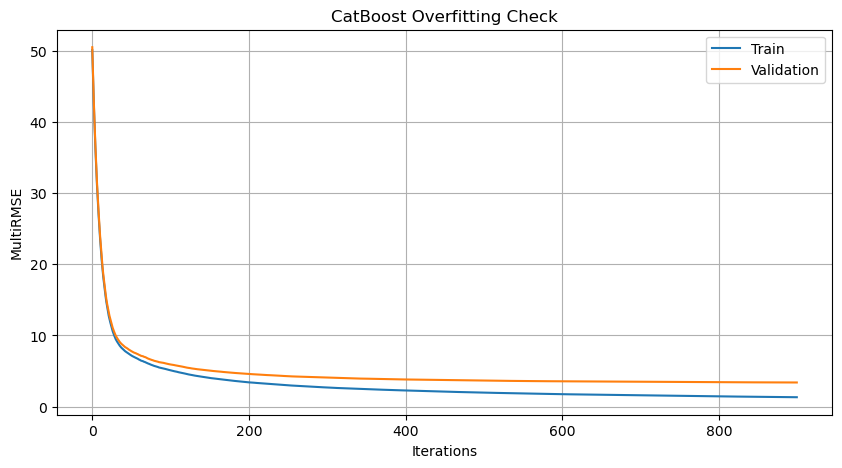

In [25]:
evals_result = model.get_evals_result()
plt.figure(figsize=(10, 5))
plt.plot(evals_result['learn']['MultiRMSE'], label='Train')
plt.plot(evals_result['validation']['MultiRMSE'], label='Validation')
plt.xlabel('Iterations')
plt.ylabel('MultiRMSE')
plt.title('CatBoost Overfitting Check')
plt.legend()
plt.grid()
plt.show()


# Evaluation

In [26]:
y_pred_cat = model.predict(X_test)
print("CatBoost Performance:")
print(f"Speed MAE: {mean_absolute_error(y_test['speed'], y_pred_cat[:, 0]):.4f}")
print(f"Travel Time MAE: {mean_absolute_error(y_test['travel_time'], y_pred_cat[:, 1]):.4f}")
print(f"Speed R²: {r2_score(y_test['speed'], y_pred_cat[:, 0]):.4f}")
print(f"Travel Time R²: {r2_score(y_test['travel_time'], y_pred_cat[:, 1]):.4f}")


CatBoost Performance:
Speed MAE: 0.5854
Travel Time MAE: 1.7843
Speed R²: 0.9943
Travel Time R²: 0.9963


# Feature Importance

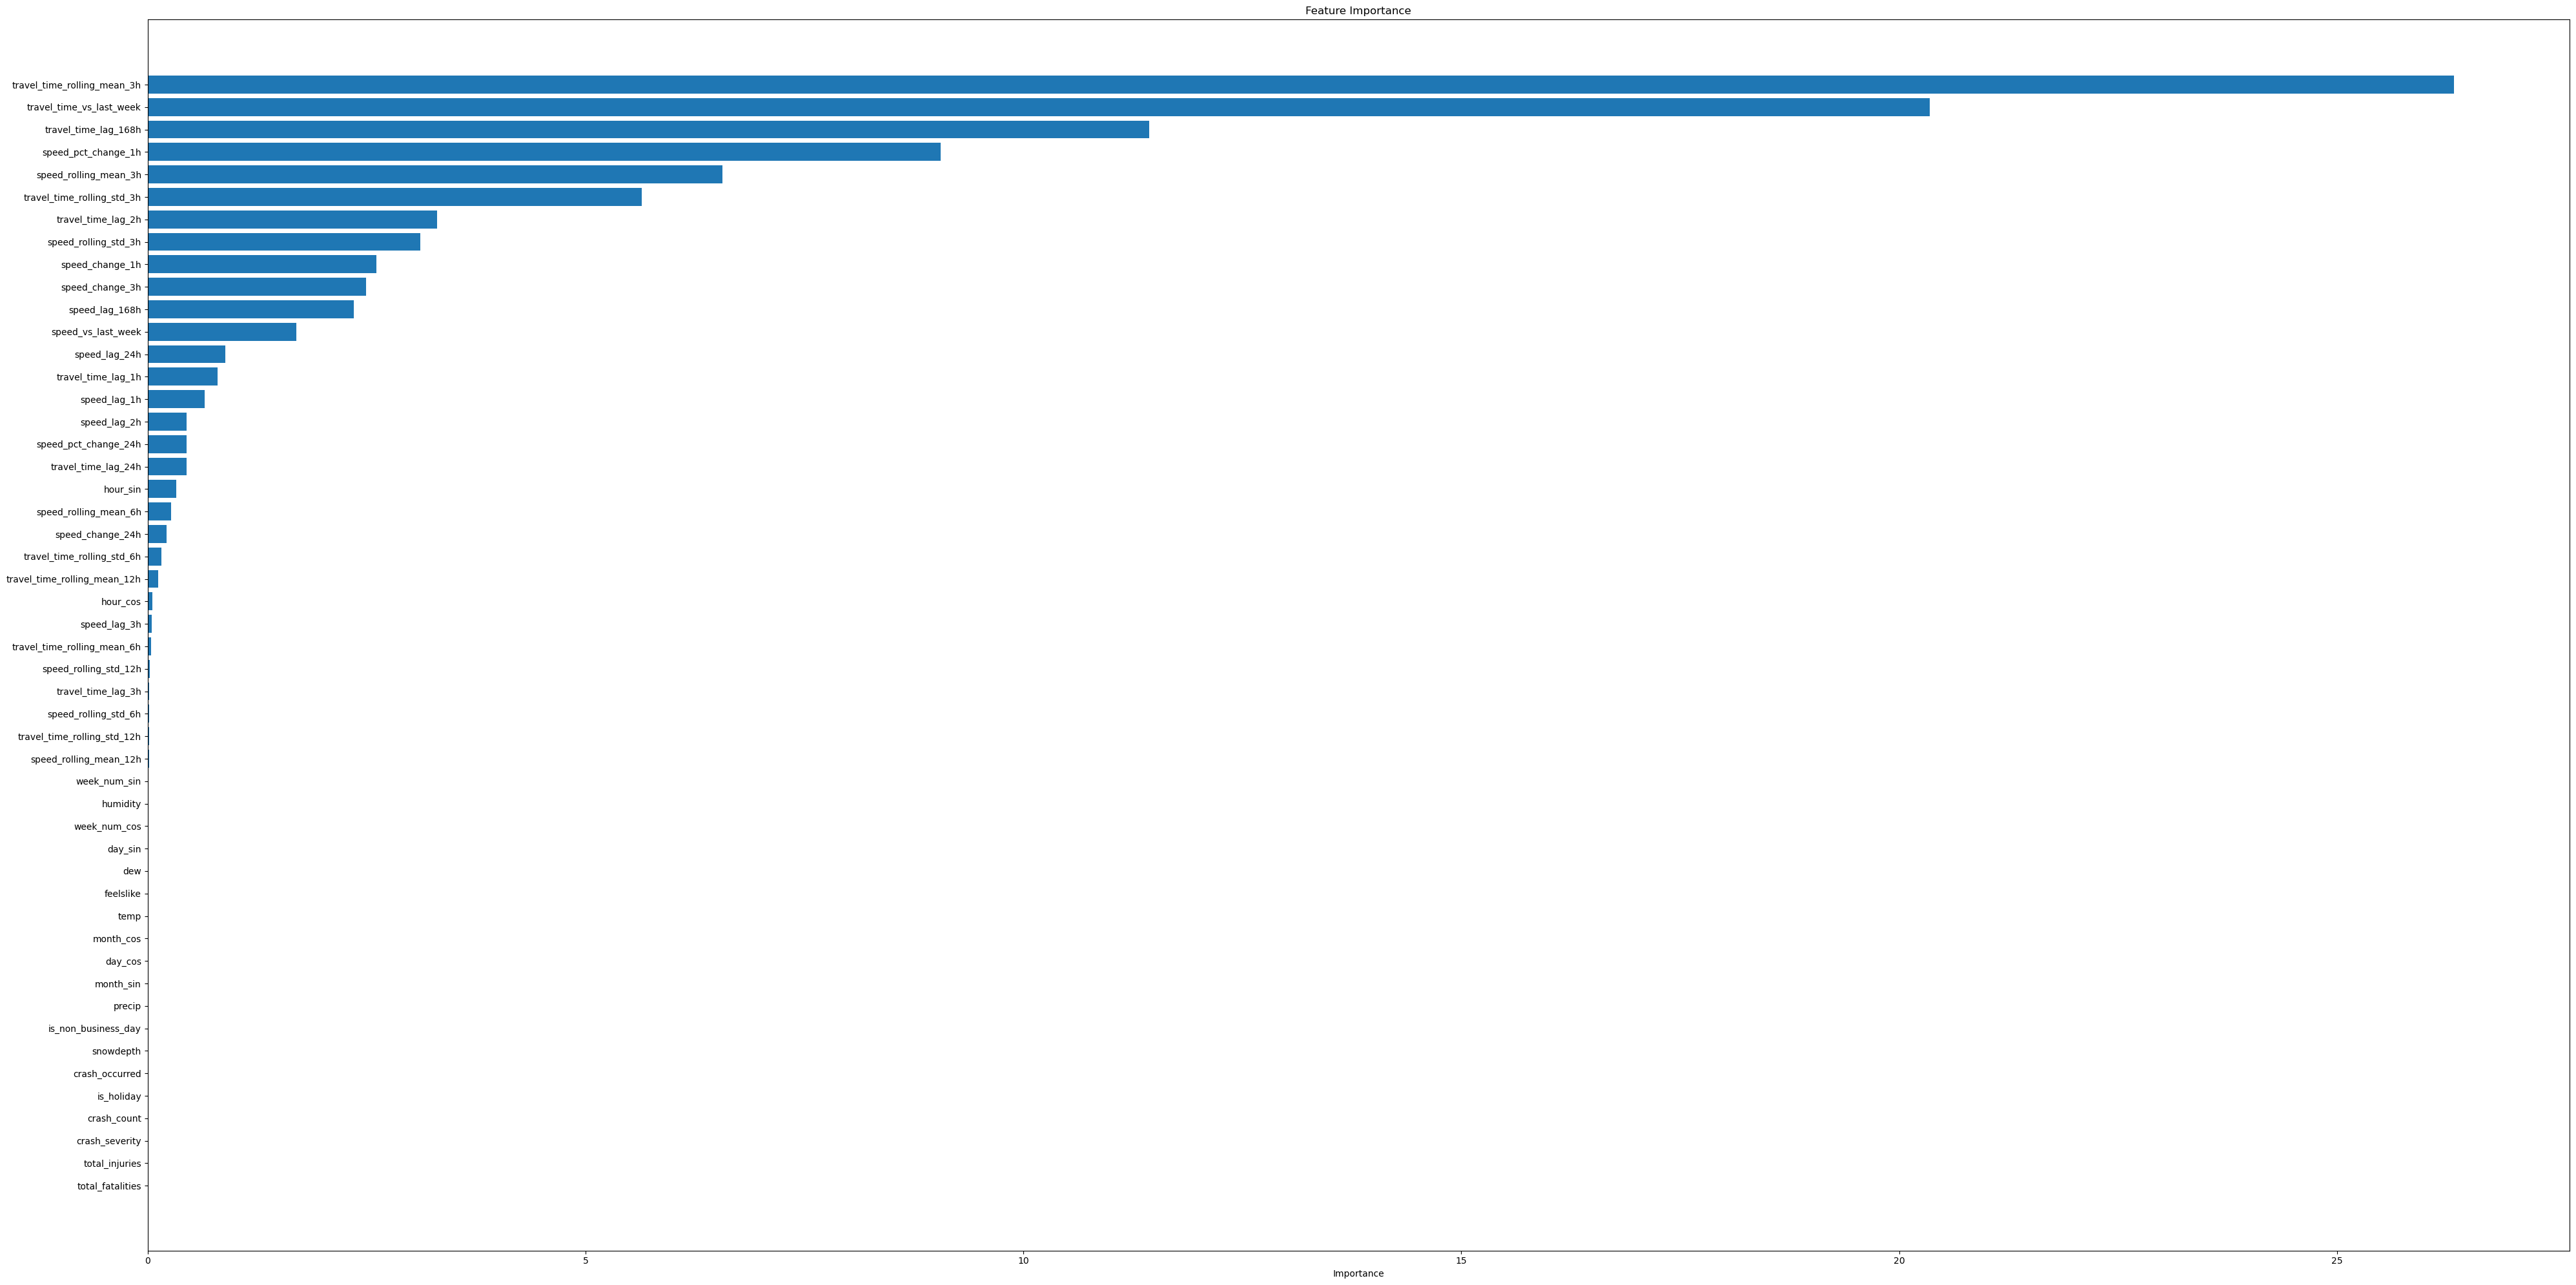

In [29]:
importances = model.get_feature_importance()
names = X_train.columns
sorted_importance = sorted(zip(names, importances), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(40, 20))
plt.barh([x[0] for x in sorted_importance[::-1]], [x[1] for x in sorted_importance[::-1]])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# Residual Analysis

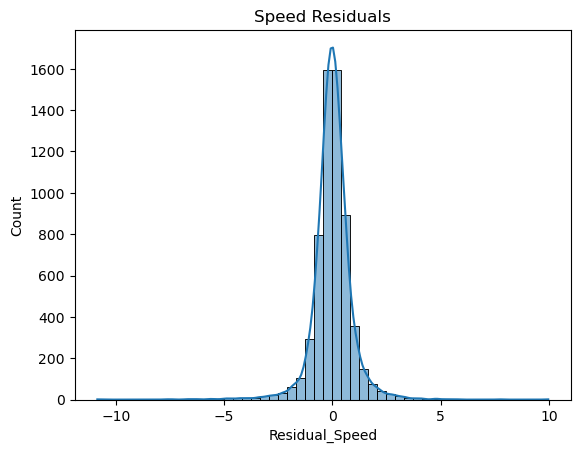

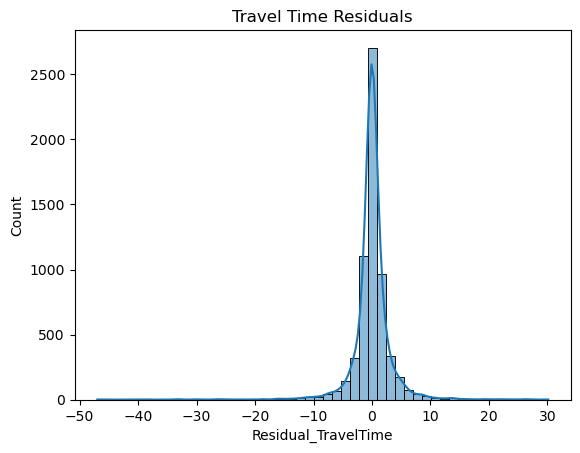

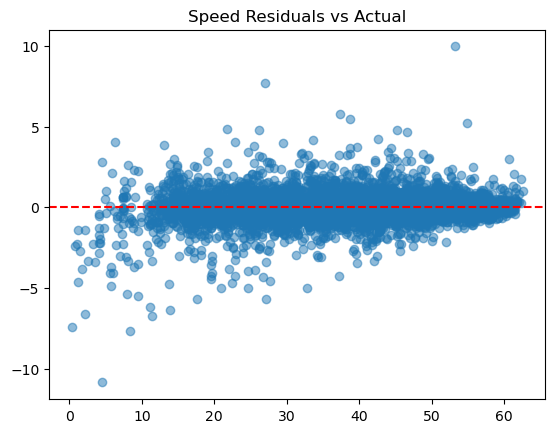

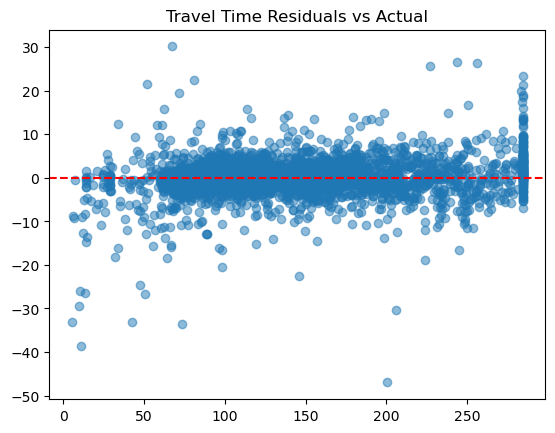

In [31]:
# Ensure target columns are numeric
y_test['speed'] = pd.to_numeric(y_test['speed'], errors='coerce')
y_test['travel_time'] = pd.to_numeric(y_test['travel_time'], errors='coerce')

y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred_cat)

residuals_speed = y_test_np[:, 0] - y_pred_np[:, 0]
residuals_travel_time = y_test_np[:, 1] - y_pred_np[:, 1]

error_df = pd.DataFrame({
    'Actual_Speed': y_test_np[:, 0],
    'Predicted_Speed': y_pred_np[:, 0],
    'Residual_Speed': residuals_speed,
    'Actual_TravelTime': y_test_np[:, 1],
    'Predicted_TravelTime': y_pred_np[:, 1],
    'Residual_TravelTime': residuals_travel_time,
})

sns.histplot(error_df['Residual_Speed'], bins=50, kde=True)
plt.title('Speed Residuals')
plt.show()

sns.histplot(error_df['Residual_TravelTime'], bins=50, kde=True)
plt.title('Travel Time Residuals')
plt.show()

plt.scatter(error_df['Actual_Speed'], error_df['Residual_Speed'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Speed Residuals vs Actual")
plt.show()

plt.scatter(error_df['Actual_TravelTime'], error_df['Residual_TravelTime'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Travel Time Residuals vs Actual")
plt.show()
